### Big change to V3: we only predict 2009-01 thru 2013-12 because of cap change: https://www.eia.gov/todayinenergy/detail.php?id=14851

This notebook is derived from Jared's notebook on the final model, containing substantive changes to the fit and prediction ranges as well as the addition of several new features. My goal here is to do some checks on the features used to ensure that the results are properly justifiable.

In [1]:
import sys
sys.path.insert(1, '../Jared')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from my_pysyncon import Dataprep, Dataprep_v2, AugSynthGPT
from my_pysyncon.utils import PlaceboTest
from scipy.stats import boxcox, skew
import scipy.stats.mstats as mstats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import the data

df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')


In [4]:
df = df_mo[df_mo['date'] < '2014-01-01']

In [5]:
# this list is used to make certain columns later

abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [ ]:
def winsorize_series_preserve_nans(s, limits):
    non_nan_mask = ~s.isna()
    s_winsor = s.copy()
    s_winsor[non_nan_mask] = mstats.winsorize(s[non_nan_mask], limits=limits)
    return s_winsor
    #return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
    #              upper=s.quantile(1-limits[1], interpolation='higher'))

In [ ]:
def winsorize_series_against_mean_preserve_nans(s, limits, window=12):
    s_sma = s.rolling(window=window).mean()
    s_delta = s - s_sma
    s_delta_winsor = s_delta.copy()
    non_nan_mask = ~s_delta.isna()
    s_delta_winsor[non_nan_mask] = mstats.winsorize(s_delta[non_nan_mask], limits=limits, nan_policy="omit")
    return s_delta_winsor + s_sma
    # For troubleshooting:
    #print(s_delta)
    #print(s_delta.clip(lower=s.quantile(limits[0], interpolation='lower'), upper=s.quantile(1-limits[1], interpolation='higher')))
    #print(s_delta)
    #return s_delta.clip(lower=s.quantile(limits[0], interpolation='lower'), upper=s.quantile(1-limits[1], interpolation='higher')) + s_sma

In [ ]:
#df_mo['date'] = pd.to_datetime(df_mo['date'])

# add a bunch of features (these will eventually get moved to combine_files.ipynb)

# Per capita calculations

df_mo['co2_per_capita'] = (df_mo['monthly_emissions'] / df_mo['monthly_population'])
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp']*10000 / df_mo['monthly_population']
df_mo['eprod_per_capita'] = (df_mo['monthly_energy_prod'] / df_mo['monthly_population'])
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
df_mo['avg_facility_age'] = (df_mo['total_facility_age']/100)/df_mo['monthly_num_plants']
df_mo['avg_weighted_facility_age'] = (df_mo['total_weighted_facility_age'])/(10**7)/df_mo['monthly_num_plants'] 

In [ ]:
# Winsorized variables
df_mo['snow_wnsr'] = winsorize_series_preserve_nans(df_mo['snow'], limits=[0.00, 0.15])
df_mo['euse_per_capita_wnsr'] = winsorize_series_preserve_nans(df_mo['euse_per_capita'], limits=[0.00, 0.05])
df_mo['monthly_renew_pct_wnsr'] = winsorize_series_preserve_nans(df_mo['monthly_renew_pct'], limits=[0.00, 0.05])

In [53]:
# Winsorized variables versus rolling average (not originally included)
df_mo['snow_wnsr_against_mean'] = winsorize_series_against_mean_preserve_nans(df_mo['snow'], limits=[0.00, 0.15])
df_mo['euse_per_capita_wnsr_against_mean'] = winsorize_series_against_mean_preserve_nans(df_mo['euse_per_capita'], limits=[0.00, 0.05])
df_mo['monthly_renew_pct_wnsr_against_mean'] = winsorize_series_against_mean_preserve_nans(df_mo['monthly_renew_pct'], limits=[0.00, 0.05])

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20155   NaN
20156   NaN
20157   NaN
20158   NaN
20159   NaN
Name: snow, Length: 20160, dtype: float64
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20155   NaN
20156   NaN
20157   NaN
20158   NaN
20159   NaN
Name: snow, Length: 20160, dtype: float64
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20155   NaN
20156   NaN
20157   NaN
20158   NaN
20159   NaN
Name: snow, Length: 20160, dtype: float64
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20155   NaN
20156   NaN
20157   NaN
20158   NaN
20159   NaN
Name: euse_per_capita, Length: 20160, dtype: float64
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20155   NaN
20156   NaN
20157   NaN
20158   NaN
20159   NaN
Name: euse_per_capita, Length: 20160, dtype: float64
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20155   NaN
20156   NaN
20157   NaN


In [15]:
# Convenience function for making the x axis easier to read
def reduce_ticks(step):
    x_ticks = plt.xticks()[0]
    # Remove ticks no
    new_x_ticks = [tick for tick in x_ticks if tick % step == 0]
    # Set the new x-ticks
    plt.xticks(new_x_ticks)

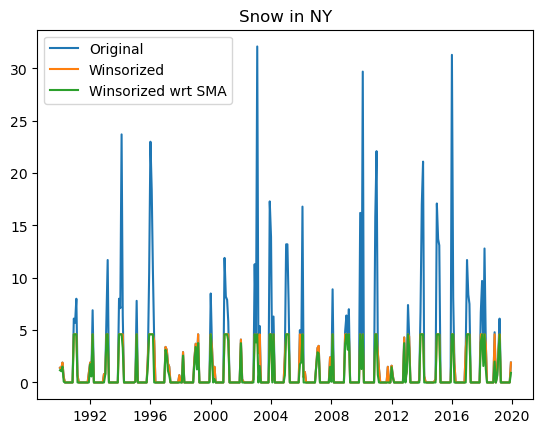

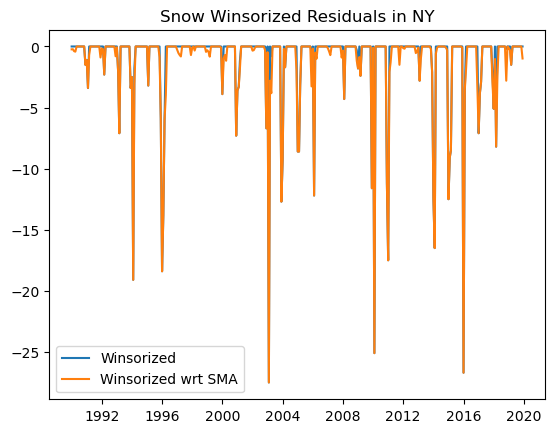

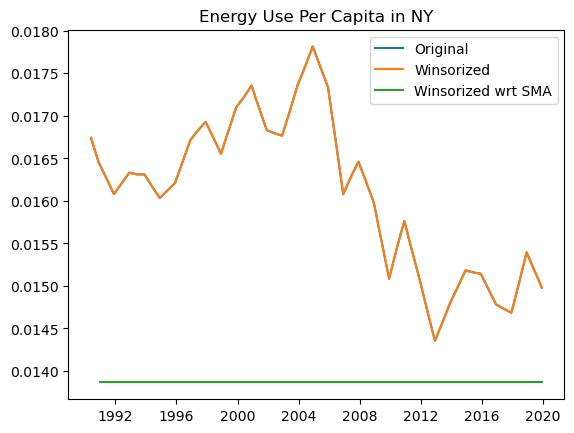

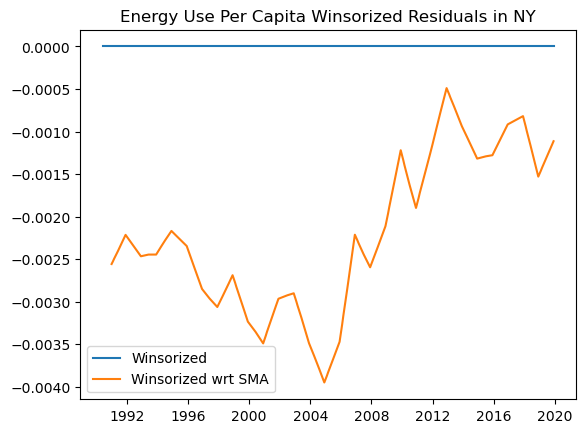

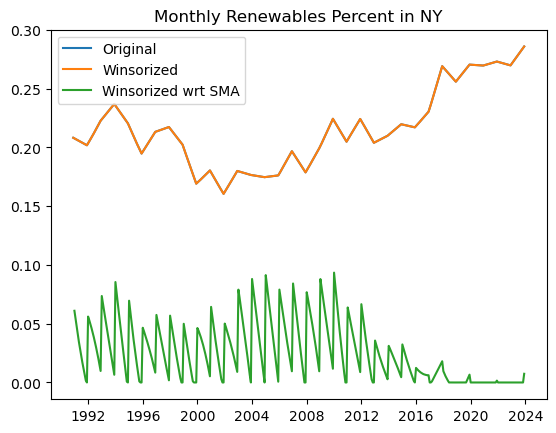

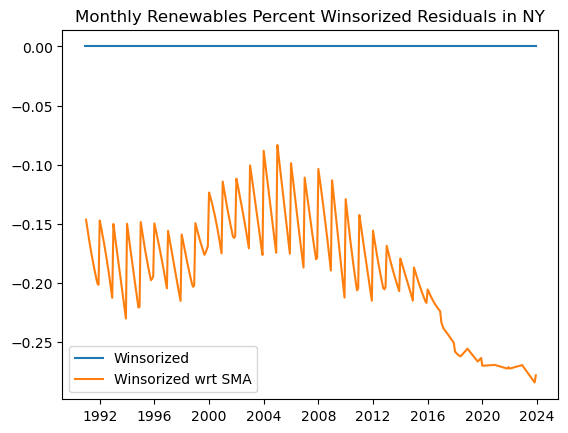

In [51]:
# Interrupt feature definitions to check the winsorized features
# Start by changing date to datetime object, this will make plotting nicer
df_ny_for_plotting = df_mo[df_mo.state=="NY"].copy(deep=True)
df_ny_for_plotting.date = pd.to_datetime(df_ny_for_plotting.date)

# Plot snow
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["snow"], label="Original")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["snow_wnsr"], label="Winsorized")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["snow_wnsr_against_mean"], label="Winsorized wrt SMA")
plt.title("Snow in NY")
plt.legend()
plt.show()

plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["snow_wnsr"] - df_ny_for_plotting["snow"], label="Winsorized")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["snow_wnsr_against_mean"] - df_ny_for_plotting["snow"], label="Winsorized wrt SMA")
plt.title("Snow Winsorized Residuals in NY")
plt.legend()
plt.show()

plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["euse_per_capita"], label="Original")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["euse_per_capita_wnsr"], label="Winsorized")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["euse_per_capita_wnsr_against_mean"], label="Winsorized wrt SMA")
plt.title("Energy Use Per Capita in NY")
plt.legend()
plt.show()

plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["euse_per_capita_wnsr"] - df_ny_for_plotting["euse_per_capita"], label="Winsorized")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["euse_per_capita_wnsr_against_mean"] - df_ny_for_plotting["euse_per_capita"], label="Winsorized wrt SMA")
plt.title("Energy Use Per Capita Winsorized Residuals in NY")
plt.legend()
plt.show()

plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["monthly_renew_pct"], label="Original")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["monthly_renew_pct_wnsr"], label="Winsorized")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["monthly_renew_pct_wnsr_against_mean"], label="Winsorized wrt SMA")
plt.title("Monthly Renewables Percent in NY")
plt.legend()
plt.show()

plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["monthly_renew_pct_wnsr"] - df_ny_for_plotting["monthly_renew_pct"], label="Winsorized")
plt.plot(df_ny_for_plotting["date"], df_ny_for_plotting["monthly_renew_pct_wnsr_against_mean"] - df_ny_for_plotting["monthly_renew_pct"], label="Winsorized wrt SMA")
plt.title("Monthly Renewables Percent Winsorized Residuals in NY")
plt.legend()
plt.show()

In [ ]:
df_mo['monthly_pop_density_log'] = np.log(df_mo['monthly_pop_density'])
df_mo['co2_per_capita_log'] = np.log(df_mo['co2_per_capita'])
df_mo['euse_per_capita_log'] = np.log(df_mo['euse_per_capita'])
df_mo['gdp_per_capita_log'] = np.log(df_mo['gdp_per_capita'])
df_mo['monthly_pop_density_log'] = np.log(df_mo['monthly_pop_density'])
df_mo['snow_wnsr_log'] = np.log1p(df_mo['snow_wnsr'])
df_mo['monthly_renew_pct_wnsr_log'] = np.log1p(df_mo['monthly_renew_pct_wnsr'])

sma_feature_list = ['monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'total_facility_age',
       'monthly_energy_total', 'yearly_energy_total', 'monthly_energy_renew',
       'yearly_energy_renew', 'monthly_renew_pct', 'yearly_renew_pct',
       'monthly_energy_fossil', 'yearly_energy_fossil', 'monthly_fossil_pct',
       'yearly_fossil_pct','monthly_energy_coal', 'yearly_energy_coal', 'monthly_coal_pct',
       'yearly_coal_pct', 'co2_per_capita',
       'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita',
       'euse_per_capita', 'avg_facility_age', 'total_weighted_facility_age','avg_weighted_facility_age','monthly_pop_density_log','co2_per_capita_log',
       'euse_per_capita_log','gdp_per_capita_log','monthly_pop_density_log','snow_wnsr','snow_wnsr_log','euse_per_capita_wnsr','monthly_renew_pct_wnsr_log']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)

df_mo['co2_per_capita_sma']= np.nan
ma_window = 6

for feature in sma_feature_list:
    for state in abbreviations:
        df_mo.loc[df_mo.state==state,feature+str('_sma')] = df_mo.loc[df_mo.state==state,feature].rolling(window=ma_window).mean()

In [148]:
features = ['eprod_per_capita_sma', 'euse_per_capita_sma', 'gdp_per_capita_sma','monthly_pop_density_sma','snow_sma', 'monthly_coal_pct_sma', 'avg_weighted_facility_age_sma', 'monthly_renew_pct_sma']

for feature in features:
    # Create a new column for the Box–Cox transformed values; initialize with NaN so that rows with missing values remain intact.
    df_mo[feature+'_boxcox'] = np.nan

    # Identify rows where 'eprod_per_capita_sma' is not missing.
    non_na_mask = df_mo[feature].notna()

    # Extract the non-missing values.
    values = df_mo.loc[non_na_mask, feature]

    # Check the minimum value among non-missing entries.
    min_val = values.min()
    print("Minimum value (non-NA) before shift:", min_val)

    # If the minimum value is <= 0, shift all values by (abs(min_val) + a small constant)
    if min_val <= 0:
        offset = abs(min_val) + 1e-6
        values_shifted = values + offset
    else:
        values_shifted = values.copy()

    # Verify that all values are now positive.
    if (values_shifted <= 0).any():
        raise ValueError("There are still non-positive values after shifting!")
    else:
        print("All non-NA values are now positive.")

    # Apply the Box–Cox transformation to the shifted non-missing values.
    values_boxcox, lambda_bc = boxcox(values_shifted)
    print("Optimal lambda for Box–Cox transformation pf", feature,"is:", lambda_bc)

    # Assign the transformed values back to the new column, keeping the original row indices intact.
    df_mo.loc[non_na_mask, feature+'_boxcox'] = values_boxcox

    # Now the column 'eprod_per_capita_sma_boxcox' contains the transformed values for rows with non-missing data,
    # while rows that originally had NA in 'eprod_per_capita_sma' remain NA.


Minimum value (non-NA) before shift: 8.469311642619983e-05
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf eprod_per_capita_sma is: -0.04595888882117683
Minimum value (non-NA) before shift: 0.013917657799429245
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf euse_per_capita_sma is: -0.8170888655098872
Minimum value (non-NA) before shift: 26.260667860162837
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf gdp_per_capita_sma is: -0.4943751441300562
Minimum value (non-NA) before shift: 0.0009419641237163
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf monthly_pop_density_sma is: -0.06334457051028106
Minimum value (non-NA) before shift: 0.0
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf snow_sma is: 0.07371069323921015
Minimum value (non-NA) before shift: -0.0001312751119214762
All non-NA values are now positive.
Optimal lambda

In [149]:
df_mo['eprod_per_capita_sma_boxcox'] = df_mo['eprod_per_capita_sma_boxcox']/10
df_mo['euse_per_capita_sma'] = df_mo['euse_per_capita_sma']*10
df_mo['tavg_sma'] = df_mo['tavg_sma']/100
df_mo['monthly_pop_density_sma_boxcox'] = df_mo['monthly_pop_density_sma_boxcox'] /10
df_mo['gdp_per_capita_sma_boxcox'] = df_mo['gdp_per_capita_sma_boxcox']
df_mo['snow'] = df_mo['snow']/10

In [150]:
df_mo['co2_per_capita_sma_log'] = np.log(df_mo['co2_per_capita_sma'])
df_mo['euse_per_capita_sma_log'] = np.log(df_mo['euse_per_capita_sma'])
df_mo['gdp_per_capita_sma_log'] = np.log(df_mo['gdp_per_capita_sma'])
df_mo['monthly_pop_density_sma_log'] = np.log(df_mo['monthly_pop_density_sma'])
df_mo['monthly_renew_pct_sma_log'] = np.log1p(df_mo['monthly_renew_pct_sma'])

In [151]:
treatment_date = '2009-01-01'
start_date = '1999-01-01'
preintervention_ma_start_date = str((pd.to_datetime(start_date)+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))
preintervention_ma_start_date_extended = str((pd.to_datetime(start_date)))


# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<treatment_date)&(df_mo.state=='MI')]


# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_energy_range = df_mo.date[(df_mo.date >= '1990-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_ma_range_extended = df_mo.date[(df_mo.date >= preintervention_ma_start_date_extended) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]


# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2013-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

In [152]:
df_mo['date_dt'] = pd.to_datetime(df_mo['date'])

# Create a new column to store the Box–Cox transformed dependent variable.
df_mo['co2_per_capita_sma_boxcox'] = np.nan

# Define masks for pre-treatment and post-treatment periods.
pre_mask = df_mo['date_dt'] < pd.to_datetime("2009-01-01")
post_mask = df_mo['date_dt'] >= pd.to_datetime("2009-01-01")

# ---------------------
# PRE-TREATMENT TRANSFORMATION
# ---------------------
# Extract non-null pre-treatment values.
pre_values = df_mo.loc[pre_mask, 'co2_per_capita_sma'].dropna()

# Determine if an offset is necessary (Box–Cox requires strictly positive values).
min_val = pre_values.min()
if min_val <= 0:
    offset = abs(min_val) + 1e-6
else:
    offset = 0.0

# Shift pre-treatment values by the offset.
pre_values_shifted = pre_values + offset

# Apply Box–Cox transformation to the shifted pre-treatment values.
transformed_pre, lambda_bc = boxcox(pre_values_shifted)
print("Optimal lambda for Box–Cox transformation is:", lambda_bc)

# Store the transformed pre-treatment values in the new column.
df_mo.loc[pre_mask & df_mo['co2_per_capita_sma'].notna(), 'co2_per_capita_sma_boxcox'] = transformed_pre

# ---------------------
# POST-TREATMENT TRANSFORMATION
# ---------------------
def apply_boxcox(x, lam, offset):
    """
    Apply the Box–Cox transformation using a given lambda and offset.
    
    For x > 0 (after applying offset):
      - If lam == 0, return log(x).
      - Otherwise, return (x^lam - 1) / lam.
    """
    x_shifted = x + offset
    if lam == 0:
        return np.log(x_shifted)
    else:
        return (np.power(x_shifted, lam) - 1) / lam

# Extract non-null post-treatment values.
post_values = df_mo.loc[post_mask, 'co2_per_capita_sma'].dropna()

# Apply the transformation using the same lambda and offset from pre-treatment.
transformed_post = apply_boxcox(post_values, lambda_bc, offset)

# Store the transformed post-treatment values.
df_mo.loc[post_mask & df_mo['co2_per_capita_sma'].notna(), 'co2_per_capita_sma_boxcox'] = transformed_post

# Now, 'co2_per_capita_sma_boxcox' contains the Box–Cox-transformed values for both pre- and post-treatment periods.


Optimal lambda for Box–Cox transformation is: 0.2511531387086594


In [153]:
# we leave off RGGI states;
# states with no CO2 data (AK, HI);
# states with some strong type of emissions program (CA, WA, OR, MN, IL);
# might be worth throwing out weaker programs (NC, MI, CO)
# and states with high increase post-treatment in CO2 per capita (ID by +67%)
# might be worth throwing out moderate increases too (AR by +13%; RI by +15%; NJ by +20%)
# states with partial RGGI participation (NJ)
# VT and RI don't have coal-fired power plants (so I want to exclude them from RGGI)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NY']    #'RI', 'VT'

non_rggi_controls_identifier= [
    "AL", 
    "AR",
    "AZ", 
    "CO", 
    "FL", 
    "GA",
    "IN", 
    "IA", 
    "KS", 
    "KY", 
    "LA", 
    "MI", 
    "MS",
    "MO", 
    "MT", 
    "NJ",
    "NE", 
    "NV", 
    "NM", 
    "NC", 
    "ND", 
    "OH", 
    "OK", 
    "PA", 
    "SC", 
    "SD", 
    "TN", 
    "TX", 
    "UT", 
    "VA",  
    "WV", 
    "WI", 
    "WY"
    ]

In [154]:
# these lists are used for treatment_time in graphs below

treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

In [155]:
preintervention_ma_range_dt = pd.to_datetime(preintervention_ma_range)
preintervention_ma_range_extended_dt = pd.to_datetime(preintervention_ma_range_extended)

In [156]:
def date_to_str(date):
    return date.dt.strftime('%Y-%m-%d')

In [157]:
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NY']

lambda = 218.46323964047764
MSE = 0.01097372266484713


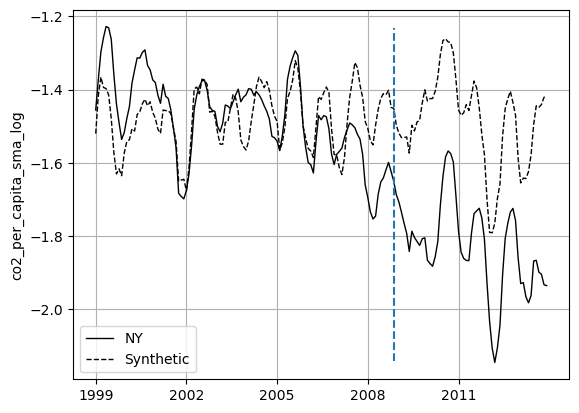

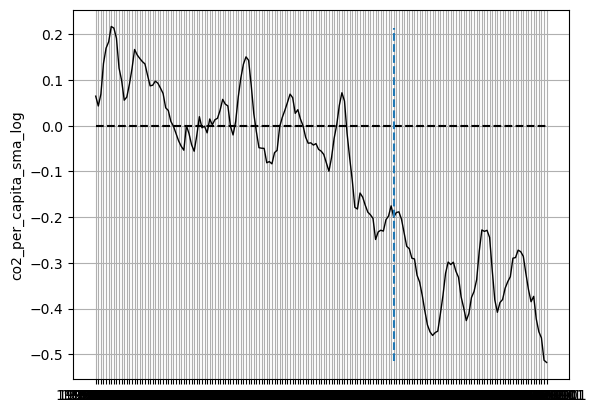

,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.avg_weighted_facility_age_sma_boxcox,0.077,-0.179,-0.117,1.310,0.568,-0.023
special.2.snow_wnsr_log_sma,0.050,0.804,0.753,0.602,0.249,0.259
special.3.co2_per_capita_sma_log,0.079,-1.530,-1.533,0.020,0.574,0.304
special.4.monthly_pop_density_sma_boxcox,0.287,-0.710,-0.657,-0.480,0.023,0.055
special.5.eprod_per_capita_sma_boxcox,0.071,-0.671,-0.588,-0.461,0.032,0.414
special.6.monthly_fossil_pct_sma,0.093,0.529,0.505,0.770,0.028,-0.314
special.7.monthly_renew_pct_wnsr_log_sma,0.071,0.165,0.100,0.050,0.007,3.553
special.8.gdp_per_capita_sma_boxcox,0.099,1.743,1.720,1.689,0.001,-0.276
special.9.monthly_coal_pct_sma,0.081,0.160,0.313,0.631,0.051,-0.083
special.10.euse_per_capita_wnsr_sma,0.093,0.017,0.026,0.032,0.000,1.207


In [158]:
# we create a synthetic control as applied to monthly_emissions SMA data
# undecided: should co2_per_capita_sma be co2_per_capita_sma_log?
# undecided: should snow_sma_boxcox be snow_wnsr_sma (with log or boxcox applied?)?
# coal % greatly increases lambda 0.06 -> 560.0 and inceases MSE for ME
# could consider month=3 AND month=9 to see if switch to solar in summer affects coal %
# fossil % slighly increases lambda, but increases MSE moreso
# excluding GDP improves NY?

dataprep_mo_ma_ny = Dataprep_v2(
    foo=df_mo,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_ma_range,
    special_predictors=[
        #('avg_facility_age_sma',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=2008)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
        ('avg_weighted_facility_age_sma_boxcox',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year ==2008)&((preintervention_ma_range_dt.dt.month ==6)|(preintervention_ma_range_dt.dt.month ==12))]), 'mean'),
        
        #('snow_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
        ('snow_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),

        #('tavg_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==9)]),'mean'),
        
        #('co2_per_capita_sma_log', ['2008-03-01'], 'mean'),
        ('co2_per_capita_sma_log', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= 1998) & (preintervention_ma_range_dt.dt.year <= 2008) &(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
             
        ('monthly_pop_density_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998) & (preintervention_ma_range_dt.dt.year<=2008)]), "mean"),     
        #('monthly_pop_density_sma_log', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998) & (preintervention_ma_range_dt.dt.year<=2008)]), "mean"),  
                  
        ('eprod_per_capita_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),  
        ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'), #|(preintervention_ma_range_dt.dt.month ==9)
        ('monthly_renew_pct_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'), #|(preintervention_ma_range_dt.dt.month ==9)

        ('gdp_per_capita_sma_boxcox',  date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998)& (preintervention_ma_range_dt.dt.year<=2008)]), 'mean'),

        ('monthly_coal_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
        ('euse_per_capita_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
        ],
    dependent="co2_per_capita_sma_log",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="NY",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )
# monthly_emissions SMA version

synth_mo_ma = AugSynthGPT()
synth_mo_ma.fit(dataprep=dataprep_mo_ma_ny)
#print(synth_mo_ma.weights())#threshold=.1
print('lambda =',synth_mo_ma.lambda_)
print('MSE =',synth_mo_ma.mspe(Z0=synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))
#print(synth_mo_ma.loss_W)

synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

#synth_mo_ma.summary()
synth_mo_ma.summary_with_variance(round=3)

In [159]:
raise ValueError('no peeking')

ValueError: no peeking

# Be wary, ye who enter here. Thar be p-values, luring ye with false promises of significance!!

In [ ]:
placebo_test_ny = PlaceboTest()
placebo_test_ny.fit(
    dataprep=dataprep_mo_ma_ny,
    scm=synth_mo_ma,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/33) Completed placebo test for NJ.
(2/33) Completed placebo test for MT.
(3/33) Completed placebo test for AR.
(4/33) Completed placebo test for FL.
(5/33) Completed placebo test for MS.
(6/33) Completed placebo test for KS.
(7/33) Completed placebo test for KY.
(8/33) Completed placebo test for MO.
(9/33) Completed placebo test for IN.
(10/33) Completed placebo test for CO.
(11/33) Completed placebo test for ND.
(12/33) Completed placebo test for NE.
(13/33) Completed placebo test for NV.
(14/33) Completed placebo test for AL.
(15/33) Completed placebo test for MI.
(16/33) Completed placebo test for SD.
(17/33) Completed placebo test for LA.
(18/33) Completed placebo test for PA.
(19/33) Completed placebo test for WY.
(20/33) Completed placebo test for IA.
(21/33) Completed placebo test for GA.
(22/33) Completed placebo test for TN.
(23/33) Completed placebo test for UT.
(24/33) Completed placebo test for AZ.
(25/33) Completed placebo test for OH.
(26/33) Completed placebo test for

In [ ]:
placebo_test_ny.pvalue(treatment_time=treatment_dates_ma[0])

0.058823529411764705

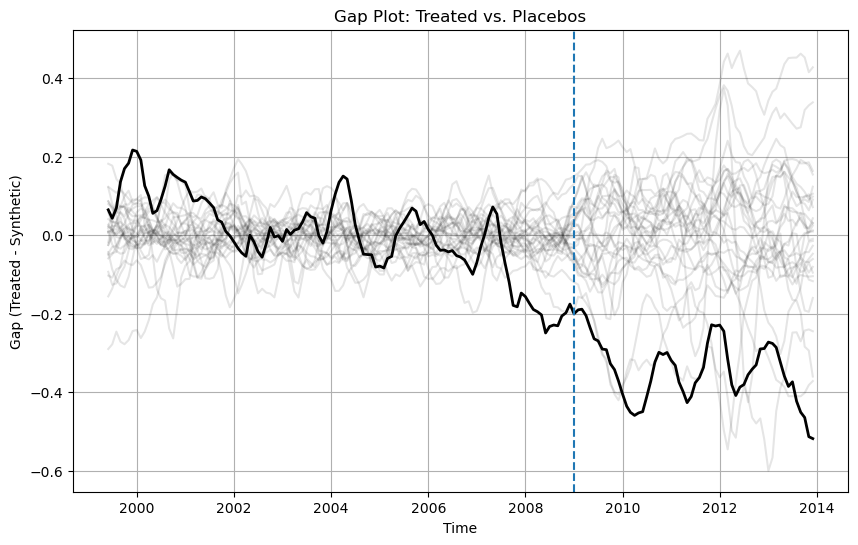

In [ ]:
placebo_test_ny.gaps_plot(
    time_period=years_sma, treatment_time=treatment_dates_ma[0], mspe_threshold=1
)